# ANOVA Demonstration

When you are testing how one or more `categorical` explanatory variables impact a `quantitative` response variable,    
the tool you should use is `Analysis of Variance (ANOVA)`    
   
`Null hypothesis` (H<sub>0</sub>): There is no association between the explanatory variable(s) and the response variable   
(H<sub>0</sub>): $\mu$<sub>1</sub> = ... = $\mu$<sub>k</sub>  
(H<sub>a</sub>): not all the $\mu$ are equal  
where $\mu$<sub>i</sub> is mean of the _i<sup>th</sup>_ category-value, and there are _k_ category-values in total

We want to be able to reject the Null Hypothesis in a statistically significant way

In this exercise, we explore the things that may influence the number of cigarettes smoked per month.

The dataset used is from the `National Epidemiologic Survey of Drug Use and Health (2001-2002)`  
This lesson is an adaptation of the `Data Analysis Tools` online course provided by Wesleyan University on Coursera.org

#### Import packages

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
pd.options.mode.chained_assignment = None
%matplotlib inline

#### Load Data

In [2]:
data = pd.read_csv('nesarc_pds.csv', low_memory=False)
data.dtypes.head()

ETHRACE2A     int64
ETOTLCA2     object
IDNUM         int64
PSU           int64
STRATUM       int64
dtype: object

In [3]:
data.head()

,ETHRACE2A,ETOTLCA2,IDNUM,PSU,STRATUM,WEIGHT,CDAY,CMON,CYEAR,REGION,...,SOL12ABDEP,SOLP12ABDEP,HAL12ABDEP,HALP12ABDEP,MAR12ABDEP,MARP12ABDEP,HER12ABDEP,HERP12ABDEP,OTHB12ABDEP,OTHBP12ABDEP
0,5,,1,4007,403,3928.613505,14,8,2001,4,...,0,0,0,0,0,0,0,0,0,0
1,5,0.0014,2,6045,604,3638.691845,12,1,2002,4,...,0,0,0,0,0,0,0,0,0,0
2,5,,3,12042,1218,5779.032025,23,11,2001,3,...,0,0,0,0,0,0,0,0,0,0
3,5,,4,17099,1704,1071.754303,9,9,2001,2,...,0,0,0,0,0,0,0,0,0,0
4,2,,5,17099,1704,4986.952377,18,10,2001,2,...,0,0,0,0,0,0,0,0,0,0


Some of the features are of the type `object` when they should be `int64` or `float64`.   
Therefore, we will change the ones we are going to use to numeric.

We are going to use the following variables for the first analysis...  
`S3AQ3B1` - "USUAL FREQUENCY WHEN SMOKED CIGARETTES"   
`S3AQ3C1` - "USUAL QUANTITY WHEN SMOKED CIGARETTES"   
`CHECK321` - "CIGARETTE SMOKING STATUS"

In [4]:
data['S3AQ3B1'] = pd.to_numeric(data["S3AQ3B1"], errors='coerce')
data['S3AQ3C1'] = pd.to_numeric(data["S3AQ3C1"], errors='coerce')
data['CHECK321'] = pd.to_numeric(data["CHECK321"], errors='coerce')

In [5]:
data[['S3AQ3B1', 'S3AQ3C1', 'CHECK321']].head()

,S3AQ3B1,S3AQ3C1,CHECK321
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


We want to select only those respondents who are between 18 and 25 years old, and who have smoked in the last year  

In [6]:
sub1=data[(data['AGE']>18) & (data['AGE']<=25) & (data['CHECK321']==1)]
sub1.head()

,ETHRACE2A,ETOTLCA2,IDNUM,PSU,STRATUM,WEIGHT,CDAY,CMON,CYEAR,REGION,...,SOL12ABDEP,SOLP12ABDEP,HAL12ABDEP,HALP12ABDEP,MAR12ABDEP,MARP12ABDEP,HER12ABDEP,HERP12ABDEP,OTHB12ABDEP,OTHBP12ABDEP
20,2,0.0099,21,36094,3616,1528.354757,2,11,2001,1,...,0,0,0,0,0,0,0,0,0,0
76,5,0.2643,77,36094,3616,6172.249980,13,3,2002,1,...,0,0,0,0,0,0,0,0,0,0
102,1,0.985,103,41097,4107,5515.974591,27,10,2001,4,...,0,0,0,1,0,1,0,0,0,0
121,1,0.8888,122,31098,3109,4152.434010,23,9,2001,2,...,0,0,0,0,0,0,0,0,0,0
135,1,0.017,136,12042,1218,8657.814391,11,12,2001,3,...,0,0,0,0,0,1,0,0,0,0


In [7]:
print("In the dataset, %.1f percent of the respondents are between 18 and 25 in age, and smoked in the past year" %(len(sub1)*100/len(data)))

In the dataset, 3.6 percent of the respondents are between 18 and 25 in age, and smoked in the past year


According to the Code Book that came with the data, `S3AQ3B1` has a value of 9 signifying 'unknown', and   
`S3AQ3C1` has a value of 99 signifying 'unknown'.  
We shown recode these to `NaN`

In [8]:
sub1['S3AQ3B1'] = sub1['S3AQ3B1'].replace(9, np.nan)
sub1['S3AQ3C1'] = sub1['S3AQ3C1'].replace(99, np.nan)

The feature `S3AQ3B1` - "USUAL FREQUENCY WHEN SMOKED CIGARETTES" - has the following coding
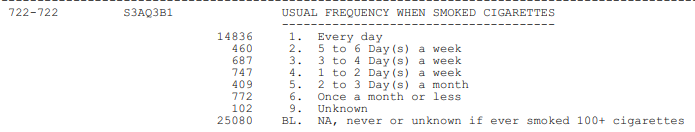   
We should recode it to get the number of days smoked per month, by averaging over the ranges specified above

In [9]:
recode = {1: 30, 2: 22, 3: 14, 4: 5, 5: 2.5, 6: 1}
sub1['DaysSmokedPerMonth'] = sub1['S3AQ3B1'].map(recode)
sub1['DaysSmokedPerMonth'].dtype

dtype('float64')

We want the number of cigarettes smoked per month. So, we have to multiply `DaysSmokedPerMonth` by `S3AQ3C1`

In [10]:
sub1['CigsSmokedPerMonth'] = sub1['DaysSmokedPerMonth'] * sub1['S3AQ3C1']
sub1['CigsSmokedPerMonth'].dtype

dtype('float64')

The first categorical variable we will test whether `MAJORDEPLIFE` - "MAJOR DEPRESSION - LIFETIME (NON-HIERARCHICAL)" - impacts the number of cigarettes smoked per month. This is a binary variable (yes or no).    

Since we are dealing with a binary variable, we only need to perform an `F-test` to test whether the average number of monthly cigarettes smoked is statistically different for someone who identifies as having major life depression or not. 

In [11]:
model = smf.ols(formula = 'CigsSmokedPerMonth ~ C(MAJORDEPLIFE)', data = sub1)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     CigsSmokedPerMonth   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     4.609
Date:                Fri, 31 Jul 2020   Prob (F-statistic):             0.0320
Time:                        14:49:36   Log-Likelihood:                -10788.
No. Observations:                1536   AIC:                         2.158e+04
Df Residuals:                    1534   BIC:                         2.159e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              310.0896 

The `F-statistic` (>0.05) above suggests that that `MAJORDEPLIFE` has a statistically significant association with `CigsSmokedPerMonth`, for young adult smokers.  
We can reject the Null Hypothesis.  
To get more resolution on this effect we can print the means and standard deviations for the number of monthly cigarettes smoked by category.

In [12]:
sub2 = sub1[['CigsSmokedPerMonth', 'MAJORDEPLIFE']].dropna()

m = sub2.groupby('MAJORDEPLIFE').mean()
print('Mean cigarettes smoked per month')
print(m)

Mean cigarettes smoked per month
              CigsSmokedPerMonth
MAJORDEPLIFE                    
0                     310.089552
1                     344.100756


In [13]:
sd = sub2.groupby('MAJORDEPLIFE').std()
print('Standard deviation of cigarettes smoked per month')
print(sd)

Standard deviation of cigarettes smoked per month
              CigsSmokedPerMonth
MAJORDEPLIFE                    
0                     263.942017
1                     293.310403


### Now let's try a categrical variable with more than two categories (i.e. not binary)
We will use the feature `ETHRACE2A` this time.  
It has five (5) categories...  
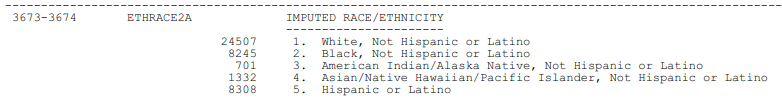

In [14]:
sub3 = sub1[['CigsSmokedPerMonth','ETHRACE2A']].dropna()

In [15]:
model2 = smf.ols(formula='CigsSmokedPerMonth ~ C(ETHRACE2A)', data=sub3).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:     CigsSmokedPerMonth   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     24.70
Date:                Fri, 31 Jul 2020   Prob (F-statistic):           7.65e-20
Time:                        14:49:36   Log-Likelihood:                -10742.
No. Observations:                1536   AIC:                         2.149e+04
Df Residuals:                    1531   BIC:                         2.152e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           368.1016      8.54

The model has chosen the first `ETHRACE2A` category value ("1. White, Not Hispanic or Latino") as the reference value.  

The `F-statistic` (>0.05) above suggests that that `ETHRACE2A` has a statistically significant association with `CigsSmokedPerMonth`, for young adult smokers.  
We can reject the Null Hypothesis. 

In [16]:
m2 = sub3.groupby('ETHRACE2A').mean()
print('Mean cigarettes smoked per month')
print(m2)

Mean cigarettes smoked per month
           CigsSmokedPerMonth
ETHRACE2A                    
1                  368.101571
2                  268.328125
3                  330.541667
4                  241.705882
5                  207.011589


In [17]:
sd2 = sub3.groupby('ETHRACE2A').std()
print('Mean cigarettes smoked per month')
print(sd2)

Mean cigarettes smoked per month
           CigsSmokedPerMonth
ETHRACE2A                    
1                  278.096760
2                  286.929624
3                  269.974638
4                  198.243693
5                  206.010303


We know, based on the above test, that there is one or more statistically significant differences between two or more of the category means. Now we need to perform a post-hoc test to figure out just where they are...

We will perform the `Tukey's Honestly Significant Difference Test`

In [18]:
import statsmodels.stats.multicomp as multi

In [19]:
mc = multi.MultiComparison(sub3['CigsSmokedPerMonth'], sub3['ETHRACE2A'])
res = mc.tukeyhsd()
print(res.summary())

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
     1      2  -99.7734  0.001 -156.8219   -42.725   True
     1      3  -37.5599    0.9  -160.021   84.9012  False
     1      4 -126.3957 0.0079 -230.0593  -22.7321   True
     1      5   -161.09  0.001 -208.7086 -113.4714   True
     2      3   62.2135 0.6694   -68.789  193.2161  False
     2      4  -26.6222    0.9 -140.2493   87.0048  False
     2      5  -61.3165 0.0876 -127.8934    5.2604  False
     3      4  -88.8358 0.5286 -245.8494   68.1779  False
     3      5 -123.5301 0.0618 -250.7098    3.6496  False
     4      5  -34.6943    0.9 -143.8919   74.5033  False
---------------------------------------------------------


Above we can see in the `reject` column the mean comparisons for which we can reject the Null Hypothesis.
It suggests that:
- Black young adults smoke fewer cigarettes than white young adults
- Asian/Native Hawaiian/Pacific Islander young adults smoke fewer cigarettes than white young adults
- Hispanic or Latino young adults smoke fewer cigarettes that white young adults

The other comparisons cannot be confirmed either way using this test.